In [1]:
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import optuna

seed = 1729
np.random.seed(seed)

/home/mgsilva/miniconda3/envs/torch_motifpredenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch import nn
import torch.optim as optim

torch.manual_seed(seed)
x = torch.rand(5, 3)
print(x)

tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
from torch.nn.utils.rnn import pad_sequence

def create_dataset(data, variable_indexes, lookback_period, step, forecast_period, motif_indexes):
    X1, X2, y = [], [], []  # X1: data, X2: indexes of the motifs, y: distance to the next motif
    
    for idx in range(len(data[0]) - lookback_period - 1):
        if idx % step != 0:
            continue

        window_end_idx = idx + lookback_period
        forecast_period_end = window_end_idx + forecast_period

        # If there are no more matches after the window, break
        if not any([window_end_idx < motif_idx for motif_idx in motif_indexes]):
            break

        # Motif indexes in window, relative to the start of the window
        motif_indexes_in_window = [motif_idx - idx for motif_idx in motif_indexes if idx <= motif_idx <= window_end_idx]
        motif_indexes_in_forecast_period = [motif_idx for motif_idx in motif_indexes if window_end_idx < motif_idx <= forecast_period_end]

        if motif_indexes_in_forecast_period:
            next_match_in_forecast_period = motif_indexes_in_forecast_period[0]
        else:
            next_match_in_forecast_period = -1  # No match in the forecast period but exists in the future

        # Get the data window and transpose to (lookback_period, num_features)
        data_window = data[variable_indexes, idx:window_end_idx].T

        # Calculate `y`
        data_y = -1
        if next_match_in_forecast_period != -1:
            # Index of the next match relative to the end of the window
            data_y = next_match_in_forecast_period - window_end_idx
        
        # Append to lists
        X1.append(torch.tensor(data_window, dtype=torch.float32))  # Now with shape (lookback_period, num_features)
        X2.append(torch.tensor(motif_indexes_in_window, dtype=torch.long)) 
        y.append(data_y) 

    # Pad X2 sequences to have the same length
    X2_padded = pad_sequence(X2, batch_first=True, padding_value=-1)
    
    # Convert lists to torch tensors
    X1 = torch.stack(X1)  # Final shape: (num_samples, lookback_period, num_features)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) 

    return X1, X2_padded, y


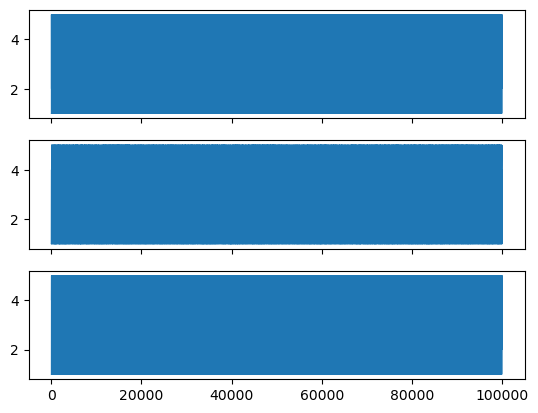

In [ ]:
#load data
n = 100000
k = 3
variable_indexes = range(k)

data_scenario3 = np.genfromtxt("../data/syntheticdata/scenario3_n={}_k={}_min_step={}_max_step={}.csv".format(n, k, 5, 45), delimiter=",").astype(int).reshape((k, n))

motif_indexes_scenario3 = np.genfromtxt("../data/syntheticdata/motif_indexes_scenario3_n={}_k={}_min_step={}_max_step={}.csv".format(n, k, 5, 45), delimiter=",").astype(int)

print(motif_indexes_scenario3) #TODO: check this


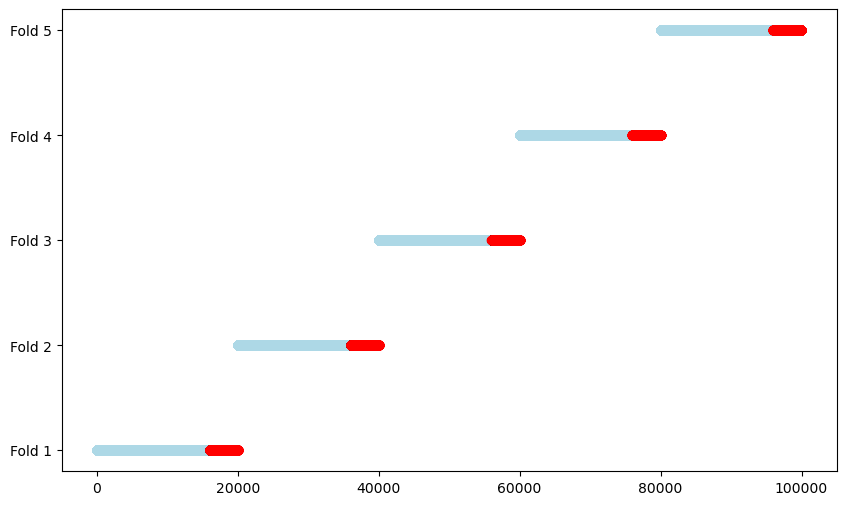

In [5]:
from timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data_scenario3[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [6]:
lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#x1: past window + masking, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2, y = create_dataset(data_scenario3, variable_indexes, lookback_period, step, forecast_period, motif_indexes_scenario3)

# X1, X2, and y are now PyTorch tensors
print("X1 shape:", X1.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X2 shape:", X2.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X1 shape: torch.Size([19977, 100, 3])
X2 shape: torch.Size([19977, 8])
y shape: torch.Size([19977, 1])


In [7]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import joblib
from typing import Tuple, List

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def evaluate_metrics(predictions: torch.Tensor, targets: torch.Tensor) -> Tuple[float, float]:
    mae = torch.mean(torch.abs(predictions - targets)).item()
    rmse = torch.sqrt(torch.mean((predictions - targets) ** 2)).item()
    return mae, rmse

def train_validate_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=500) -> float:
    early_stopper = EarlyStopper(patience=10, min_delta=1e-5)
    for epoch in range(num_epochs):
        model.train()
        for batch_X1, batch_y in train_loader:
            batch_X1, batch_y = batch_X1.to(device), batch_y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(batch_X1), batch_y)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X1, batch_y in val_loader:
                batch_X1, batch_y = batch_X1.to(device), batch_y.to(device)
                val_loss += criterion(model(batch_X1), batch_y).item()
        avg_val_loss = val_loss / len(val_loader)

        # Early stopping
        if epoch >= 100:
            if early_stopper.early_stop(avg_val_loss):
                print(f"Early stopping at epoch {epoch + 1}")
                break
    return early_stopper.min_validation_loss



In [ ]:
from models.lstm_pytorch import LSTMX1Input

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = X1.shape[2]  # Number of features in X1
output_size = 1   

def objective_lstm_x1(trial) -> float:
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    hidden_size = trial.suggest_categorical("hidden_size", [16, 32, 64, 128, 256])
    num_layers = trial.suggest_categorical("num_layers", [1, 2, 3])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    fold_results, test_mae_per_fold, test_rmse_per_fold = [], [], []

    for fold, (train_idx, test_idx) in enumerate(BlockingTimeSeriesSplit(n_splits=5).split(X1)):
        X1_train, X1_test = X1[train_idx], X1[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        val_index = int(0.8 * X1_train.shape[0])

        X1_train, X1_val = X1_train[:val_index], X1_train[val_index:]
        y_train, y_val = y_train[:val_index], y_train[val_index:]

        # Fit the MinMaxScaler on the training data only and transform train, val, and test data
        scaler_X1 = MinMaxScaler(feature_range=(0, 1))
        X1_train = torch.tensor(scaler_X1.fit_transform(X1_train.view(-1, X1_train.shape[-1])), dtype=torch.float32).view(X1_train.shape)
        X1_val = torch.tensor(scaler_X1.transform(X1_val.view(-1, X1_val.shape[-1])), dtype=torch.float32).view(X1_val.shape)
        X1_test = torch.tensor(scaler_X1.transform(X1_test.view(-1, X1_test.shape[-1])), dtype=torch.float32).view(X1_test.shape)

        train_loader = DataLoader(TensorDataset(X1_train, y_train), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X1_val, y_val), batch_size=len(X1_val), shuffle=False)
        test_loader = DataLoader(TensorDataset(X1_test, y_test), batch_size=len(X1_test), shuffle=False)

        model = LSTMX1Input(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).to(device)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        fold_val_loss = train_validate_model(model, criterion, optimizer, train_loader, val_loader)
        fold_results.append(fold_val_loss)

        # Test evaluation
        all_predictions, all_true_values = [], []
        model.eval()
        with torch.no_grad():
            for batch_X1, batch_y in test_loader:
                batch_X1, batch_y = batch_X1.to(device), batch_y.to(device)
                outputs = model(batch_X1).squeeze()
                all_predictions.append(outputs)
                all_true_values.append(batch_y)

        all_predictions = torch.cat(all_predictions)
        all_true_values = torch.cat(all_true_values)
        mae, rmse = evaluate_metrics(all_predictions, all_true_values)
        test_mae_per_fold.append(mae)
        test_rmse_per_fold.append(rmse)

    mean_val_loss = np.mean(fold_results)
    mean_test_mae, std_test_mae = np.mean(test_mae_per_fold), np.std(test_mae_per_fold)
    mean_test_rmse, std_test_rmse = np.mean(test_rmse_per_fold), np.std(test_rmse_per_fold)

    with open("results_LSTMX1Input.csv", mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "trial_number", "learning_rate", "batch_size", "hidden_size", "num_layers",
            "fold_1_val_loss", "fold_2_val_loss", "fold_3_val_loss", "fold_4_val_loss", "fold_5_val_loss",
            "avg_validation_loss", "test_mae_mean", "test_mae_std", "test_rmse_mean", "test_rmse_std"
        ])
        writer.writerow([
            trial.number, learning_rate, batch_size, hidden_size, num_layers,
            *fold_results, mean_val_loss, mean_test_mae, std_test_mae, mean_test_rmse, std_test_rmse
        ])
        file.flush()

    return mean_val_loss


def run_optuna_study(objective_func, file_name: str, n_trials: int = 100):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=seed))
    study.optimize(objective_func, n_trials=n_trials)
    joblib.dump(study, file_name)
    print("Best hyperparameters:", study.best_params)
    print("Best cross-validated validation loss:", study.best_value)


# Run the study for LSTM with X1 input
run_optuna_study(objective_lstm_x1, "synthetic_data_LSTMX1Input.pkl")

[I 2024-11-07 17:32:44,345] A new study created in memory with name: no-name-ceb78800-4661-4a90-bdb4-ba905d7e768f


Early stopping at epoch 144
Early stopping at epoch 126
Early stopping at epoch 289
Early stopping at epoch 168


[I 2024-11-07 17:37:27,117] Trial 0 finished with value: 104.01853485107422 and parameters: {'learning_rate': 2.6565450821928437e-05, 'hidden_size': 256, 'num_layers': 3, 'batch_size': 64}. Best is trial 0 with value: 104.01853485107422.


Early stopping at epoch 283
Early stopping at epoch 125
Early stopping at epoch 129
Early stopping at epoch 208
Early stopping at epoch 118


[I 2024-11-07 17:40:32,265] Trial 1 finished with value: 59.19865188598633 and parameters: {'learning_rate': 0.00010461160323948997, 'hidden_size': 128, 'num_layers': 2, 'batch_size': 16}. Best is trial 1 with value: 59.19865188598633.


Early stopping at epoch 130
Early stopping at epoch 272
Early stopping at epoch 245
Early stopping at epoch 272
Early stopping at epoch 180


[I 2024-11-07 17:41:39,287] Trial 2 finished with value: 77.85519409179688 and parameters: {'learning_rate': 8.234629491061175e-05, 'hidden_size': 128, 'num_layers': 1, 'batch_size': 64}. Best is trial 1 with value: 59.19865188598633.


Early stopping at epoch 269
Early stopping at epoch 451
Early stopping at epoch 448


In [ ]:
from models.lstm_pytorch import LSTMX1_X2BeforeLSTM


# Model parameters
input_size = X1.shape[2]  # Number of features in X1
output_size = 1           

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Open the CSV file to log Optuna results
with open("optuna_tuning_results.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    # Write the header including columns for each fold's validation loss, average validation loss, test MAE, test RMSE, and their standard deviations
    writer.writerow(["trial_number", "learning_rate", "batch_size", "hidden_size", "num_layers",
                     "fold_1_val_loss", "fold_2_val_loss", "fold_3_val_loss", "fold_4_val_loss", "fold_5_val_loss",
                     "avg_validation_loss", "test_mae_mean", "test_mae_std", "test_rmse_mean", "test_rmse_std"])

    # Define the Optuna objective function
    def objective(trial):
        # Define hyperparameters to tune
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        hidden_size = trial.suggest_categorical("hidden_size", [16, 32, 64, 128, 256])
        num_layers = trial.suggest_categorical("num_layers", [1, 2, 3])
        batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

        # Placeholder for fold validation losses
        fold_results = []
        
        # Placeholders for test MAE and RMSE for each fold
        test_mae_per_fold, test_rmse_per_fold = [], []

        # Cross-validation with BlockingTimeSeriesSplit
        for fold, (train_idx, test_idx) in enumerate(BlockingTimeSeriesSplit(n_splits=5).split(X1)):
            # Split train and test sets for each fold
            X1_train, X1_test = X1[train_idx], X1[test_idx]
            X2_train, X2_test = X2[train_idx], X2[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Split train into train and validation (80-20 split)
            val_index = int(0.8 * X1_train.shape[0])
            X1_train, X1_val = X1_train[:val_index], X1_train[val_index:]
            X2_train, X2_val = X2_train[:val_index], X2_train[val_index:]
            y_train, y_val = y_train[:val_index], y_train[val_index:]

            # Fit the MinMaxScaler on the training data only and transform train, val, and test data
            scaler_X1 = MinMaxScaler(feature_range=(0, 1))
            X1_train = torch.tensor(scaler_X1.fit_transform(X1_train.view(-1, X1_train.shape[-1])), dtype=torch.float32).view(X1_train.shape)
            X1_val = torch.tensor(scaler_X1.transform(X1_val.view(-1, X1_val.shape[-1])), dtype=torch.float32).view(X1_val.shape)
            X1_test = torch.tensor(scaler_X1.transform(X1_test.view(-1, X1_test.shape[-1])), dtype=torch.float32).view(X1_test.shape)

            # Create DataLoader for train, validation, and test sets
            train_loader = DataLoader(TensorDataset(X1_train, X2_train, y_train), batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(TensorDataset(X1_val, X2_val, y_val), batch_size= len(X1_val), shuffle=False)  # Use the whole validation set at once
            test_loader = DataLoader(TensorDataset(X1_test, X2_test, y_test), batch_size= len(X1_test), shuffle=False) # Use the whole test set at once

            # Initialize model, loss function, and optimizer
            model = LSTMX1_X2BeforeLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).to(device)
            early_stopper = EarlyStopper(patience=10, min_delta=1e-5)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            
            # Training loop for the fold
            num_epochs = 500

            for epoch in range(num_epochs):
                model.train()
                for batch_X1, batch_X2, batch_y in train_loader:
                    batch_X1, batch_X2, batch_y = batch_X1.to(device), batch_X2.to(device), batch_y.to(device)
                    
                    # Forward pass
                    outputs = model(batch_X1, batch_X2)
                    loss = criterion(outputs, batch_y)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # Validation phase - evaluate on validation set after each epoch
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch_X1, batch_X2, batch_y in val_loader:
                        batch_X1, batch_X2, batch_y = batch_X1.to(device), batch_X2.to(device), batch_y.to(device)
                        outputs = model(batch_X1, batch_X2)
                        loss = criterion(outputs, batch_y)
                        val_loss += loss.item()
                avg_val_loss = val_loss / len(val_loader)

                # Early stopping check using EarlyStopper
                if epoch >= 100:
                    if early_stopper.early_stop(avg_val_loss):
                        print(f"Early stopping at epoch {epoch}")
                        break

            # Append the best validation loss encountered during this fold
            fold_results.append(early_stopper.min_validation_loss)

        
            # Evaluate on test set for the current fold
            all_predictions, all_true_values  = [], []
            model.eval()
            with torch.no_grad():
                for batch_X1, batch_X2, batch_y in test_loader:
                    batch_X1, batch_X2, batch_y = batch_X1.to(device), batch_X2.to(device), batch_y.to(device)

                    # Predict and store results
                    outputs = model(batch_X1, batch_X2).squeeze()
                    all_predictions.append(outputs)
                    all_true_values.append(batch_y)


            # Compute MAE and RMSE for this fold and store them
            all_predictions = torch.cat(all_predictions)
            all_true_values = torch.cat(all_true_values)
            test_mae_per_fold.append(torch.mean(torch.abs(all_predictions - all_true_values)).item())
            test_rmse_per_fold.append(torch.sqrt(torch.mean((all_predictions - all_true_values) ** 2)).item())


        # Calculate the mean and std of validation loss, test MAE, and test RMSE across folds
        mean_val_loss = np.mean(fold_results)
        mean_test_mae = np.mean(test_mae_per_fold)
        std_test_mae = np.std(test_mae_per_fold)
        mean_test_rmse = np.mean(test_rmse_per_fold)
        std_test_rmse = np.std(test_rmse_per_fold)

        # Log results for this trial
        writer.writerow([trial.number, learning_rate, batch_size, hidden_size, num_layers] + 
                        fold_results + [mean_val_loss, mean_test_mae, std_test_mae, mean_test_rmse, std_test_rmse])
        file.flush()  # Ensure each trial result is written immediately

        # Return the mean validation loss across folds for Optuna to optimize
        return mean_val_loss

    # Run the Optuna study
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    joblib.dump(study, "synthetic_data_LSTMX1_X2BeforeLSTM.pkl")

    # Print the best hyperparameters and validation loss
    print("Best hyperparameters:", study.best_params)
    print("Best cross-validated validation loss:", study.best_value)
